# Library Imports

## Create a local VENV and PIP Install Requirements

## Optimization libraries

In [1]:
import optuna
from numba import jit
from joblib import parallel_backend, effective_n_jobs

c:\Users\willa\Documents\GitHub\CNN_Cancer_Detector\DTSA-5511_CNN_Cancer_Detector\CNN_Cancer_Detection\cnn_cancer_detector_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Standard Libraries

In [4]:
# libraries for file manipulation and warning handling
import os
import subprocess
import time
import logging
import warnings
from tqdm import tqdm
from joblib import dump, load
import gc

# Libraries for data handling
import re
import math
import random
import numpy as np
import pandas as pd
from collections import Counter

#imports for model training and validation
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, average_precision_score, auc, roc_auc_score
from sklearn.metrics import precision_recall_curve, roc_curve, classification_report, confusion_matrix

#Recursive Feature Elimination
from sklearn.feature_selection import RFE 

#imports for preprocessing our data
from sklearn.utils import shuffle

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, label_binarize, FunctionTransformer
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer, make_column_selector
from mlxtend.feature_selection import ColumnSelector

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion

#imports for our classifier models
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

#imports for plotting
import seaborn as sns
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patheffects as pe
%matplotlib inline

#imports for attractive printing of dataframes
from IPython.display import display

## Computer Vision and Tensorflow Imports

In [10]:
import cv2 

from PIL import Image
from PIL import ImageDraw
train_on_gpu = True

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,optimizers,models,callbacks
from keras.metrics import AUC

## Custom Module Imports from src

In [14]:
import src.kaggle_extractor as extract

## Function Defs

In [15]:
class data_handler:
    def __init__(self, competition_name, usr_path="./data/"):
        self.competition_name = competition_name
        extract.Kaggle_Competition_Extract(self.competition_name)
        self.labels, self.sample_submission = self.file_to_data(usr_path)
        self.img_train_dir, self.img_train, self.img_test_dir, self.img_test = self.img_to_list(usr_path)
        
    def file_to_data(self, usr_path):
        files = [i for i in os.walk("./data")][0]
        for file in files[-1]:
            if '.csv' in file.lower():
                if 'train' in file.lower(): 
                    df_train_labels = pd.read_csv(usr_path + file)
                elif 'sample' in file.lower():
                    df_sample = pd.read_csv(usr_path + file)
        return df_train_labels, df_sample
    
    def img_to_list(self, usr_path):
        train_dir = usr_path + "/train/"
        test_dir = usr_path + "/test/"

        img_train = pd.Series(os.listdir(train_dir))
        img_test = pd.Series(os.listdir(test_dir))

        print("Number of training images: {}".format(len(img_train)))
        print("Number of testing images: {}".format(len(img_test)))

        return train_dir, img_train, test_dir, img_test

    # def encode_categories(self):
    #     encoder = LabelEncoder()
    #     self.y_train_encoded = encoder.fit_transform(self.y_train)
    #     self.y_test_encoded = encoder.transform(self.y_test)

#  Exploratory Data Analysis

## Dataset Description:

Our dataset is a collection of 96x96 pixel color images of lymph node sections and their associated binary labels for presence of cancer.

If an image has a label of 1 then it is a malignant sample, if it has a label of 0 then it is a benign/normal sample. Malignant samples are those which have at least 1 pixel of cancerous tissue within the 32x32 pixel center of the image.

This dataset is a modification of the PatchCamelyon benchmark dataset.

Our training set consists of 220025 images, all labels non-null.

Our test set consists of 57458 images, all labels non-null.

We have a dataframe holding the training data and a dataframe holding a sample prediction, both of the following format:

|Column|Type|Description|
|---------|----|:--------:|
|id| String | the file name of the image |
|label| int | the binary (0,1) representaiton of negative or positive cancer result |

The sample submisison simply provides the expected format of the prediction to submit to kaggle, it is not a test label set.

### Acknowledgements

This dataset was provided by Kaggle via Bas Veeling, with additional input from Babak Ehteshami Bejnordi, Geert Litjens, and Jeroen van der Laak.

You may view and download the official Pcam dataset from GitHub. The data is provided under the CC0 License, following the license of Camelyon16.

If you use PCam in a scientific publication, please reference the following papers:

[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

## Exploration

In [16]:
competition_name = 'histopathologic-cancer-detection'
data = data_handler(competition_name)

Making /data/ subfolder
Competition files downloaded.
Extracting files...
Files extracted
Cleaning up data directory...

Data directory ready!
Number of training images: 220025
Number of testing images: 57458


In [256]:
data.labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [257]:
data.labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


### Target Feature Class Balance

There is a marginal bias towards the non-malignant label in the training data sample.

This implies that our training data is no representative of a population distribution of malignancy.

In [258]:
data.labels['label'].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

Text(0.5, 1.0, 'Label Frequency in Training Set')

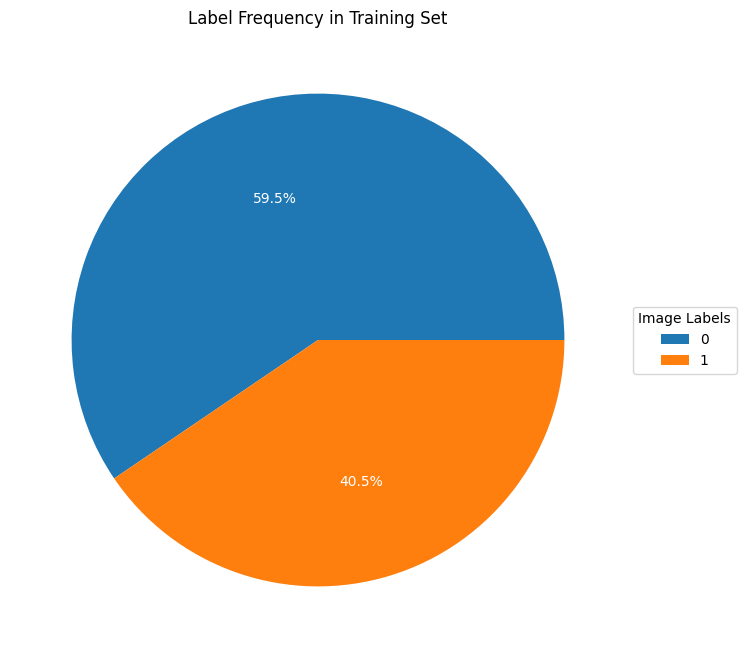

In [165]:
pie_data=(data.labels.groupby('label').agg('count')/len(data.labels)).unstack().to_frame().reset_index().drop(columns=['level_0']).rename(columns={0:'value'})

pie_data
fig, ax = plt.subplots(figsize=(32, 8), subplot_kw=dict(aspect="equal"))
ax.pie(x=pie_data['value'], labels=pie_data['label'], autopct='%.1f%%', textprops=dict(color='w'))
ax.legend(title='Image Labels', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
ax.set_title('Label Frequency in Training Set')

### Preview (Random Sampling of Malignant and Non-Malignant Lymph Node Section Images)

A visual observation of malignancy is not a simple task, cancerous samples are not easily distinguishable to a laymen.

Inspecting the randomly sampled lymph node sections it is clear that an expert opinion is needed, which is time-consuming and cost-prohibitive at scale.

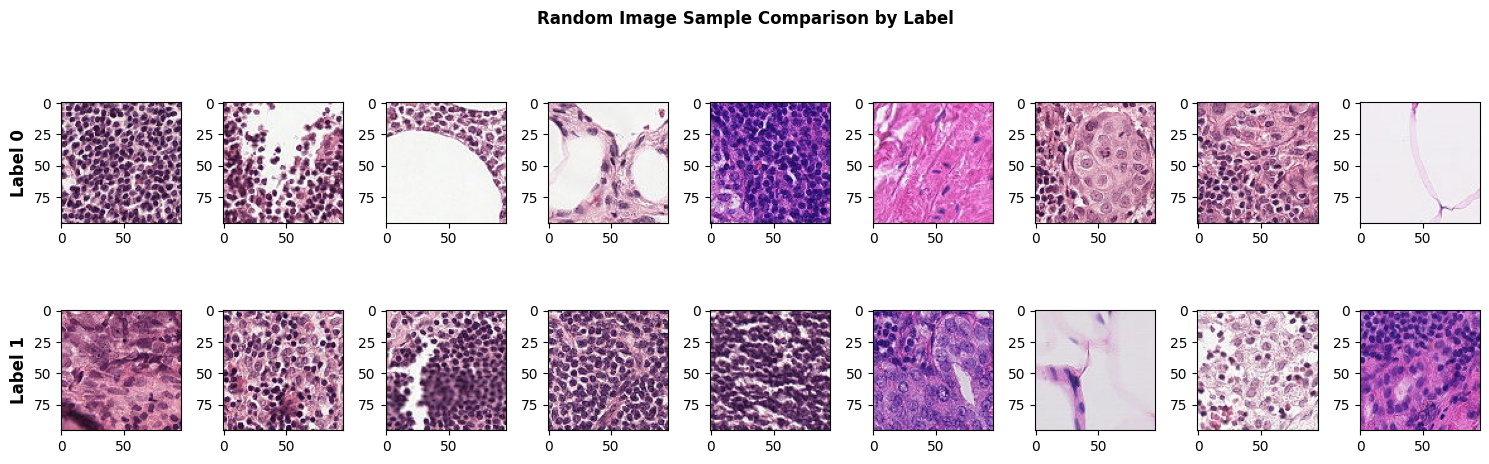

In [284]:
fig, axes = plt.subplots(2, 9, figsize=(15,5))

# randomized order, but index unchanged
df_neg = data.labels[data.labels['label'] == 0].sample(frac=1)
df_pos = data.labels[data.labels['label'] == 1].sample(frac=1)

for i in range(9):
    # negative label image column
    row_index = df_neg.index[i]
    im = Image.open(data.img_train_dir + data.img_train[row_index])
    axes[0, i].imshow(im)
    #id_label = data.labels.filter(items=[row_index], axis=0)['id'].values[0]
    #axes[i, 0].set_title(f"img#{id_label}")

    # positive label image column
    row_index = df_pos.index[i]
    im = Image.open(data.img_train_dir + data.img_train[row_index])
    axes[1, i].imshow(im)
    #label = data.labels.filter(items=[row_index], axis=0)['label'].values[0]
    #axes[i, 1].set_title(f"#{i+1} - Label: {label}")

rows = ['Label 0', 'Label 1']
#for ax, col in zip(axes[0], cols):
#    ax.set_title(col)

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large', fontweight='bold')
    
fig.suptitle("Random Image Sample Comparison by Label", fontweight='bold')
fig.tight_layout()

# Data Preparation

In [ ]:
# Some constants

IMG_SIZE = 96
IMG_CHANNELS = 3
SAMPLE_SIZE = 80000 # may adjust based on label distribution

In [ ]:
# prepare even training set

# train, validation split

# ImageGen prep

# Image Augmentations

Image classification can benefit from transformation of the training dataset, where augmenting the images may give a larger training set size or help prevent the presentation of the images from affecting the classification.

As tumor malignancy is not affected by altering our images, we can apply common image transforms such as rotation, resizing, or flipping to increase the size and variation of the set of images we train on.

<u><b>Notes:</b></u>

Additionally, it may be interesting to see if feeding a model both the base and transformed variations of an image may improve classification.

Other augmentations may include color channel splitting, contrast adjustment, etc.

In [449]:
#Handle ArticleId
#Mismatched size after processing, would drop later anyway since it is a unique identifier
# pass_articleid = ColumnSelector(cols=('ArticleId'), drop_axis = True)
# pass_articleid_pipe = Pipeline([('pass_article', pass_articleid)])

#vector_count
word_count_vectorizer = CountVectorizer(analyzer='word', max_features=5000)
word2count_pipe = Pipeline([
    ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
    ('word2count', word_count_vectorizer)
])

#Term Frequency - Inverse Document Frequency (TF-IDF)
#Word-Level
word_vectorizer = TfidfVectorizer(analyzer='word', max_features=5000)
word2vec_pipe = Pipeline([
    ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
    ('word2vec', word_vectorizer)
])

#N-gram Level
ngram_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(2, 3), max_features=5000)
ngram2vec_pipe = Pipeline([
    ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
    ('ngram2vec', ngram_vectorizer)
])


#Character Level
character_vectorizer = TfidfVectorizer(analyzer='char', token_pattern=r'\w{1,}', ngram_range=(2,3), max_features=5000)
char2vec_pipe = Pipeline([
    ('Selector', ColumnSelector(cols=('Text'), drop_axis = True)),
    ('char2vec', character_vectorizer)
])


#Feature Union of Pipelines
feats = FeatureUnion([('word_count', word2count_pipe), 
                      ('word_vec', word2vec_pipe),
                      ('ngram_vec', ngram2vec_pipe),
                      ('char_vec', char2vec_pipe)
                      ], transformer_weights=None, verbose=True)

feature_processing = Pipeline([('feats', feats)])

In [450]:
feature_processing.fit_transform(data.full_train)

[FeatureUnion] .... (step 1 of 4) Processing word_count, total=   0.3s
[FeatureUnion] ...... (step 2 of 4) Processing word_vec, total=   0.3s
[FeatureUnion] ..... (step 3 of 4) Processing ngram_vec, total=   2.3s


C:\Users\willa\Documents\WinPython64\WPy64-31150\python-3.11.5.amd64\Lib\site-packages\sklearn\feature_extraction\text.py:555: UserWarning: The parameter 'token_pattern' will not be used since 'analyzer' != 'word'
  warnings.warn(


[FeatureUnion] ...... (step 4 of 4) Processing char_vec, total=   1.7s


<1490x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 2378741 stored elements in Compressed Sparse Row format>

# Model Architecture

- In
- [Conv2D*3 -> MaxPool2D -> Dropout]*[IMG_CHANNELS] -> (filters = 16, 32, 64)
- Flatten
- Dense (256)
- Dropout
- Out

In [ ]:
KERNEL_SIZE = (3,3)
POOL_SIZE = (2,2)
FIRST_FILTERS = 32
SECOND_FILTERS = 64
THIRD_FILTERS = 128

DROPOUT_CONV = 0.3
DROPOUT_DENSE = 0.5

ACTIVATION_FN = 'relu' # should be softmax?

In [ ]:
model = models.Sequential()
#Input Layer
model.add(
    layers.Conv2D(
        FIRST_FILTERS
        , KERNEL_SIZE
        , activation = ACTIVATION_FN
        , input_shape = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)
    )
)
#First Conv Layer
model.add(
    layers.Conv2D(
        FIRST_FILTERS
        , KERNEL_SIZE
        , use_bias = False
    )
)
model.add(
    layers.BatchNormalization()
)
model.add(
    layers.Activation(
        ACTIVATION_FN
    )
)
model.add(
    layers.MaxPool2D(
        pool_size = POOL_SIZE
    )
)
model.add(
    layers.Dropout(
        DROPOUT_CONV
    )
)
#Second Conv Layer
model.add(
    layers.Conv2D(
        FIRST_FILTERS
        , KERNEL_SIZE
        , use_bias = False
    )
)
model.add(
    layers.BatchNormalization()
)
model.add(
    layers.Activation(
        ACTIVATION_FN
    )
)
model.add(
    layers.Conv2D(
        FIRST_FILTERS
        , KERNEL_SIZE
        , use_bias = False
    )
)
model.add(
    layers.BatchNormalization()
)
model.add(
    layers.Activation(
        ACTIVATION_FN
    )
)
model.add(
    layers.MaxPool2D(
        pool_size = POOL_SIZE
    )
)
model.add(
    layers.Dropout(
        DROPOUT_CONV
    )
)
#Third Conv Layer
model.add(
    layers.Conv2D(
        FIRST_FILTERS
        , KERNEL_SIZE
        , use_bias = False
    )
)
model.add(
    layers.BatchNormalization()
)
model.add(
    layers.Activation(
        ACTIVATION_FN
    )
)
model.add(
    layers.Conv2D(
        FIRST_FILTERS
        , KERNEL_SIZE
        , use_bias = False
    )
)
model.add(
    layers.BatchNormalization()
)
model.add(
    layers.Activation(
        ACTIVATION_FN
    )
)
model.add(
    layers.MaxPool2D(
        pool_size = POOL_SIZE
    )
)
model.add(
    layers.Dropout(
        DROPOUT_CONV
    )
)
#Output Layer
model.add(
    layers.Flatten()
)
model.add(
    layers.Dense(
        256
        , use_bias = False
    )
)
model.add(
    layers.BatchNormalization()
)
model.add(
    layers.Activation(
        ACTIVATION_FN
    )
)
model.add(
    layers.Dropout(
        DROPOUT_DENSE
    )
)
model.add(
    layers.Dense(
        1
        , activation = 'sigmoid'
    )
)

In [ ]:
model.compile(
    optimizers.Adam(0.01)
    , loss = 'binary_crossentropy'
    , metrics = ['accuracy']
)

# Model Training

In [ ]:
earlystopper = callbacks.EarlyStopping(
    monitor = 'val_loss'
    , patience = 2
    , verbose = 1
    , restore_best_weights = True
)

reducer = callbacks.ReduceLROnPlateau(
    monitor = 'val_loss'
    , patience = 1
    , verbose = 1
    , factor = 0.1
)

model_history = model.fit_generator(
    #training_generator
    , steps_per_epoch = TRAIN_STEPS
    , #validation_data=validation_generator
    , validation_steps = VAL_STEPS
    , epochs = 13
    , callbacks = [reducer, earlystopper]
)

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# make a prediction
y_preds = model.predict_generator(test_gen, steps=len(df_val), verbose=1)
fpr, tpr, thresholds = roc_curve(test_gen.classes, y_preds)
auc_preds = auc(fpr, tpr)
auc_preds

In [472]:
#Base case model using LogRegClassifier
model = LogisticRegression(random_state=5, max_iter=10000)
model.fit(data.X_train_vectorized, data.y_train_encoded)
y_pred = model.predict(data.X_test_vectorized)

accuracy_score(y_pred, data.y_test_encoded)

0.19183673469387755

# Model Evaluation 

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='area = {:.3f}'.format(auc_preds))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

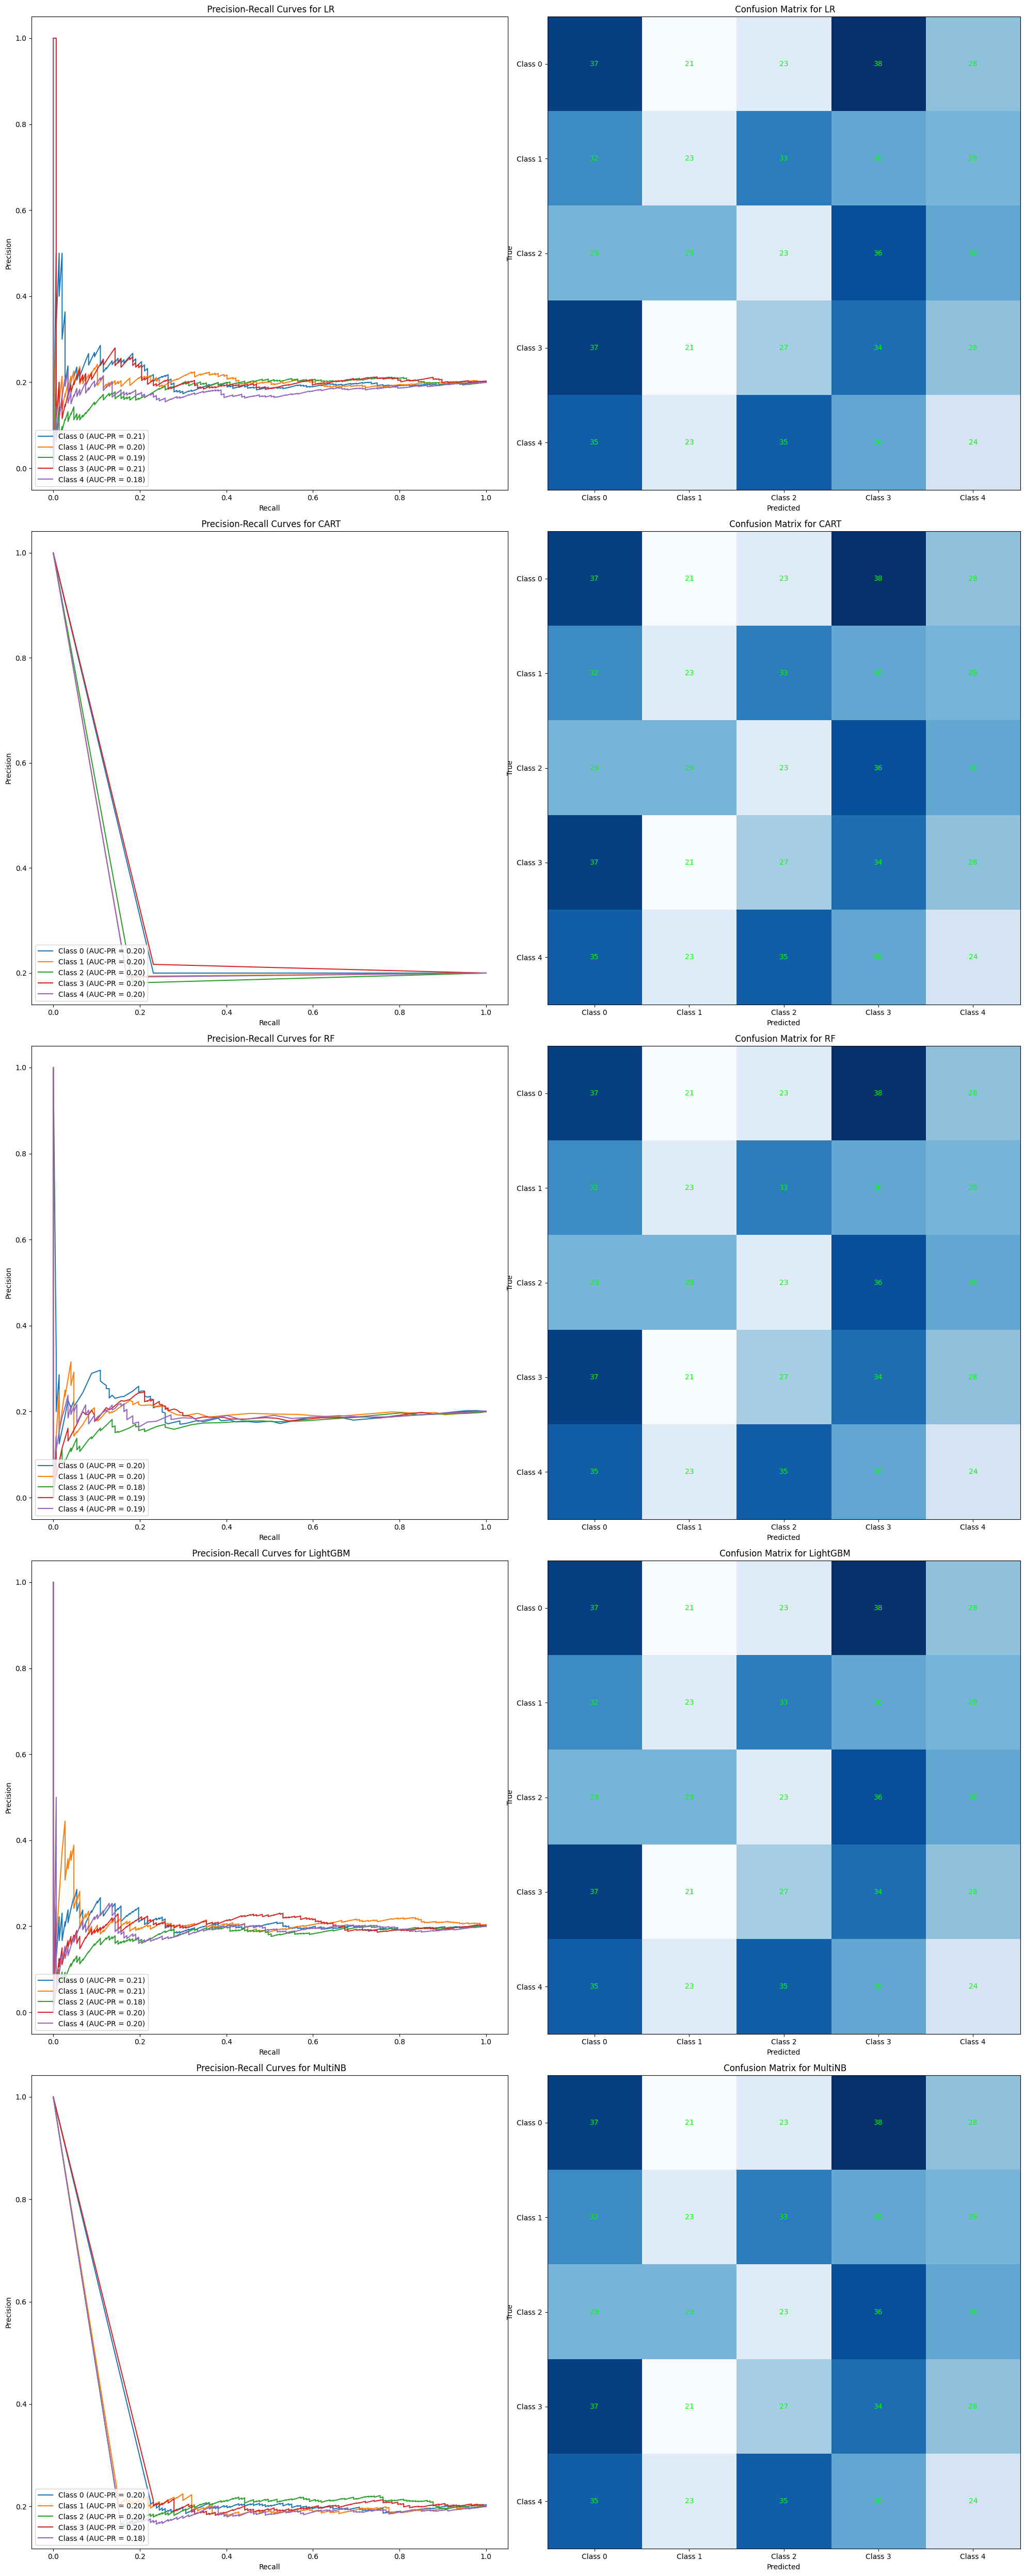

In [487]:
evaluate_and_plot_models(names, best_models, data.X_test_vectorized, data.y_test_encoded, plot_pr_curves=True)

In [492]:
for name, model in zip(names, best_models):
    print(name)
    print(classification_report(data.y_test_encoded, model.predict(data.X_test_vectorized)))

LR
              precision    recall  f1-score   support

           0       0.21      0.24      0.22       147
           1       0.20      0.16      0.18       147
           2       0.16      0.16      0.16       147
           3       0.20      0.23      0.22       147
           4       0.17      0.17      0.17       147

    accuracy                           0.19       735
   macro avg       0.19      0.19      0.19       735
weighted avg       0.19      0.19      0.19       735

CART
              precision    recall  f1-score   support

           0       0.20      0.23      0.21       147
           1       0.19      0.17      0.18       147
           2       0.18      0.18      0.18       147
           3       0.22      0.23      0.22       147
           4       0.19      0.17      0.18       147

    accuracy                           0.20       735
   macro avg       0.20      0.20      0.20       735
weighted avg       0.20      0.20      0.20       735

RF
           

# Predict on Test